In [48]:
from pynq import Overlay, allocate, PL
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import time
import os

PL.reset()

In [2]:
overlay = Overlay("./design_1.bit")

In [3]:
print(overlay.ip_dict.keys())

dict_keys(['toyuv_0', 'axi_dma_0', 'axi_dma_1', 'axi_dma_2', 'processing_system7_0'])


In [4]:
ip = overlay.toyuv_0

In [5]:
for name, props in overlay.ip_dict.items():
    base = props.get('phys_addr') or props.get('phys_addr_range') or props.get('addr_range') or props.get('base_addr') or None
    size = props.get('addr_range') or props.get('phys_addr_range') or props.get('range') or None

    print(f"{name:30s} @ {base!s:12s}  size {size!s}")

toyuv_0                        @ 1073741824    size 65536
axi_dma_0                      @ 1105199104    size 65536
axi_dma_1                      @ 1105264640    size 65536
axi_dma_2                      @ 1105330176    size 65536
processing_system7_0           @ None          size None


In [6]:
dma0 = overlay.axi_dma_0
dma0_send = overlay.axi_dma_0.sendchannel
dma0_recv = overlay.axi_dma_0.recvchannel

dma1 = overlay.axi_dma_1
dma1_send = overlay.axi_dma_1.sendchannel
dma1_recv = overlay.axi_dma_1.recvchannel

dma2 = overlay.axi_dma_2
dma2_send = overlay.axi_dma_2.sendchannel
dma2_recv = overlay.axi_dma_2.recvchannel

In [7]:
def image_read(fname):
    im = cv2.imread(fname, cv2.IMREAD_COLOR)
    if im is None:
        raise ValueError(f"Image at path '{fname}' could not be read.")

    height, width = im.shape[:2]
    B, G, R = cv2.split(im)

    return width, height, R, G, B

In [27]:
width, height, R, G, B = image_read("./input.jpg")

In [28]:
R = R.astype(np.int32)
G = G.astype(np.int32)
B = B.astype(np.int32)

In [29]:
def get_register_offset(overlay, ip, parameter):
    return overlay.ip_dict[ip]['registers'][parameter]['address_offset']

WIDTH_ADDR = get_register_offset(overlay, "toyuv_0", "width")
HEIGHT_ADDR = get_register_offset(overlay, "toyuv_0", "height")

In [30]:
ip.write(WIDTH_ADDR, width)
ip.write(HEIGHT_ADDR, height)

In [31]:
CONTROL_REGISTER = 0x0
ip.write(CONTROL_REGISTER, 0x81)

In [52]:
total = width * height

r = allocate(shape=(total,), dtype=np.int32)
g = allocate(shape=(total,), dtype=np.int32)
b = allocate(shape=(total,), dtype=np.int32)

y = allocate(shape=(total,), dtype=np.int32)
u = allocate(shape=(total,), dtype=np.int32)
v = allocate(shape=(total,), dtype=np.int32)

In [53]:
for i in range(height):
    for j in range(width):
        r[j + width*i] = R[i][j]
        g[j + width*i] = G[i][j]
        b[j + width*i] = B[i][j]

In [54]:
dma0_rc = dma0.recvchannel
dma0_sd = dma0.sendchannel

dma1_rc = dma1.recvchannel
dma1_sd = dma1.sendchannel

dma2_rc = dma2.recvchannel
dma2_sd = dma2.sendchannel

In [55]:
def transfer(in0, in1, in2, out0, out1, out2):
    print(in0, in1, in2, out0, out1, out2)
    dma0_sd.transfer(in0)
    dma1_sd.transfer(in1)
    dma2_sd.transfer(in2)
    print("Send done") 
    
    dma0_rc.transfer(out0)
    dma1_rc.transfer(out1)
    dma2_rc.transfer(out2)
    print("Receive done")
    
    dma0_sd.wait()   
    print("Send wait 0")
    
    dma1_sd.wait()   
    print("Send wait 1") 
    
    dma2_sd.wait()   
    print("Send wait 2")
    
    dma0_rc.wait()
    print("Receive wait 0")
    
    dma1_rc.wait()
    print("Receive wait 1")
    
    dma2_rc.wait()
    print("Receive wait 2")

In [56]:
transfer(r, g, b, y, u, v)

[ 0  0  0 ... 19 19 19] [ 0  0  0 ... 45 45 45] [ 0  0  0 ... 70 70 70] [0 0 0 ... 0 0 0] [0 0 0 ... 0 0 0] [0 0 0 ... 0 0 0]
Send done
Receive done
Send wait 0
Send wait 1
Send wait 2
Receive wait 0
Receive wait 1
Receive wait 2


In [57]:
y, u, v

(PynqBuffer([ 0,  0,  0, ..., 51, 51, 51]),
 PynqBuffer([  0,   0,   0, ..., -28, -28, -28]),
 PynqBuffer([ 0,  0,  0, ..., -3, -3, -3]))

In [58]:
np.min(y), np.max(y)

(PynqBuffer(0), PynqBuffer(196))

In [59]:
np.min(u), np.max(u)

(PynqBuffer(-125), PynqBuffer(129))

In [60]:
np.min(v), np.max(v)

(PynqBuffer(-82), PynqBuffer(88))

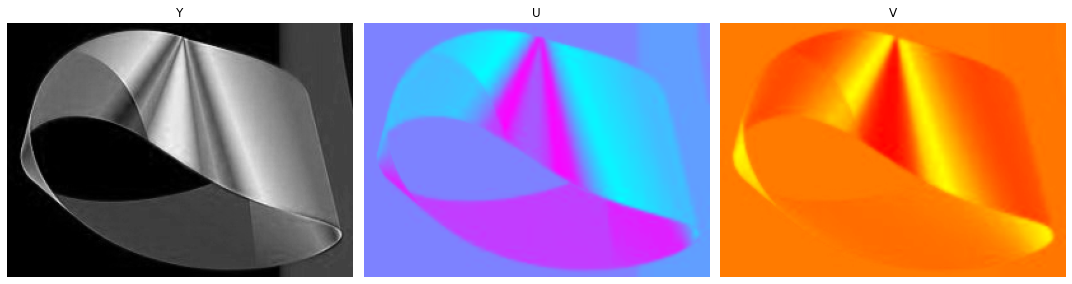

In [61]:
y_img = y.reshape(height, width)
u_img = u.reshape(height, width)
v_img = v.reshape(height, width)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# y
axes[0].imshow(y_img, cmap='gray')
axes[0].set_title('Y')
axes[0].axis('off')

# u
axes[1].imshow(u_img, cmap='cool')
axes[1].set_title('U')
axes[1].axis('off')

# v
axes[2].imshow(v_img, cmap='autumn')
axes[2].set_title('V')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [64]:
def yuv_to_rgb(height, width, Y, U, V):
    Y = Y.reshape((height, width))
    U = U.reshape((height, width))
    V = V.reshape((height, width))

    R = Y + 1.13983 * V
    G = Y - 0.39465 * U - 0.58060 * V
    B = Y + 2.03211 * U

    R = np.clip(R, 0, 255).astype(np.uint8)
    G = np.clip(G, 0, 255).astype(np.uint8)
    B = np.clip(B, 0, 255).astype(np.uint8)

    return np.stack((B, R, G), axis=-1)

rgb_restored = yuv_to_rgb(height, width, y, u, v)

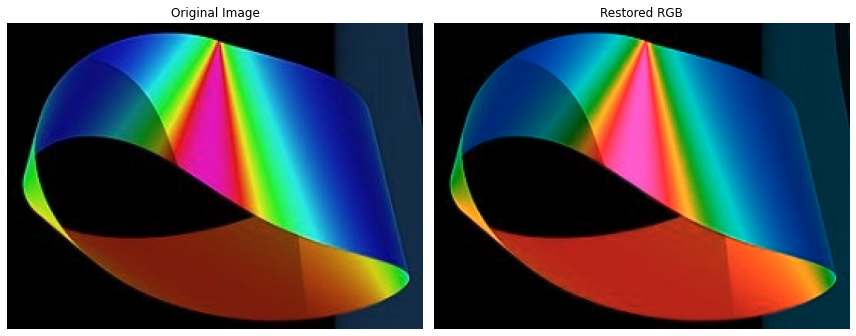

In [65]:
original = mpimg.imread('input.jpg')

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# original
axs[0].imshow(original)
axs[0].set_title("Original Image")
axs[0].axis('off')

# restaured
axs[1].imshow(rgb_restored)
axs[1].set_title("Restored RGB")
axs[1].axis('off')

plt.tight_layout()
plt.show()

In [50]:
del y, u, v, r, g, b